In [62]:
import os
import pickle

import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt

import tensorflow as tf

#from librosa.feature import melspectrogram, rms
#from librosa.display import specshow
#from librosa import load as librosa_load

from segment import segment_spectrogram
from modules.labels import get_label_vector

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Constants
# Audio
SR = 44100
TRANSFORMS = [None]

# STFT params
HOP = 441
WINDOW_SIZES = [2**10,2**11,2**12]
CONTEXT = 7
MELS = 80
FMIN = 27.5
FMAX = 16000.0

In [3]:
# Configure plots
def melspecshow(data, ax=None):
    return specshow(data, ax=ax, sr=SR, hop_length=HOP, n_fft=WINDOW_SIZES[0], y_axis='mel', x_axis='s', fmin=FMIN, fmax=FMAX)

In [4]:
!ls "datasets/OnsetLabeledInstr2013/development/Violin"

42954_FreqMan_hoochie_violin_pt1.onsets my_violin2.wav
42954_FreqMan_hoochie_violin_pt1.wav    my_violin3.onsets
my_violin1.onsets                       my_violin3.wav
my_violin1.wav                          violin2.onsets
my_violin2.onsets                       violin2.wav


In [71]:
audio_fnames = ["datasets/OnsetLabeledInstr2013/development/Violin/42954_FreqMan_hoochie_violin_pt1.wav"]
label_fnames = ["datasets/OnsetLabeledInstr2013/development/Violin/42954_FreqMan_hoochie_violin_pt1.onsets"]

# Un-Normalization - find better way
audios = [32767*librosa_load(path, sr=SR)[0] for path in audio_fnames]
onset_schedules = [genfromtxt(label_fname, delimiter=',') for label_fname in label_fnames]


NameError: name 'librosa_load' is not defined

In [6]:
mm_sig = np.load("results/processor_test/sig.npy")

In [7]:
[print("Name of rec: {}\n"
       "Len in seconds: {:.2f}\n"
       "Shape of audio: {}\n"
       "Shape of onset schedule: {}\n"
       "Onsets from {:.2f}s to {:.2f}s\n"
       "Mean RMS: {}".format(
                                        os.path.split(fname)[1], 
                                        audio.shape[0]/44100,
                                        audio.shape,
                                        schedule.shape,
                                        schedule.min(),
                                        schedule.max(),
                                        np.mean(rms(y=audio)),
                                        ) 
    ) for fname, audio, schedule in zip(audio_fnames, audios, onset_schedules)
]

Name of rec: 42954_FreqMan_hoochie_violin_pt1.wav
Len in seconds: 10.55
Shape of audio: (465257,)
Shape of onset schedule: (30,)
Onsets from 0.03s to 10.25s
Mean RMS: 2487.75390625


[None]

In [8]:
mm_frames = np.load("results/processor_test/frames.npy")
print(mm_frames[0,:])
print(np.convolve(mm_sig, np.hamming(1024), mode='same'))

[ 0  0  0 ... 29 54 63]
[  -753.93532081   -743.65267092   -733.45554698 ... -16773.86293929
 -16651.44328005 -16535.97632509]


(513, 1056)


/Users/simonfal/anaconda3/envs/tfrosa/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  return f(*args, **kwargs)


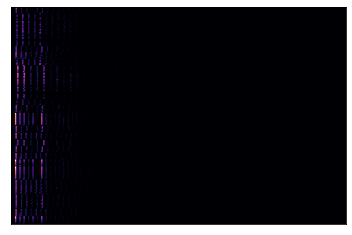

In [9]:
# Compute STFT
from librosa import stft
stfts = [stft(
    y=audio, 
    n_fft=1024, 
    hop_length=441,
    win_length=1024,
    window=np.hanning,
    center=True,
    ) for audio in audios]

print(stfts[0].shape)

# Load STFT from file
mm_stft = np.load("results/processor_test/stft.npy")
specshow(mm_stft)


1
3
(80, 1056)


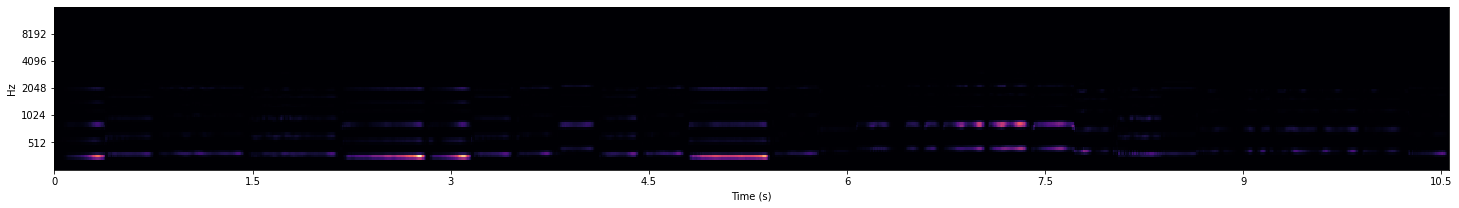

In [10]:
# Compute spectrograms
spects_per_file = [
    [
        #[
            melspectrogram(y=audio, 
                            sr=SR,
                            hop_length=HOP,
                            win_length=window_size,
                            n_fft=window_size,
                            n_mels=MELS,
                            fmin=FMIN,
                            fmax=FMAX,
                            norm="slaney"
            ) for window_size in WINDOW_SIZES
        #] for transform in TRANSFORMS
    ] for audio in audios
]
#Should be number of files
print(len(spects_per_file))
#Should be number of channels
print(len(spects_per_file[0]))
#Should be (channel, frames)
print(spects_per_file[0][0].shape)
#Example spectrogram
fig, axs = plt.subplots(figsize=(25,3))
melspecshow(spects_per_file[0][0], ax=axs)

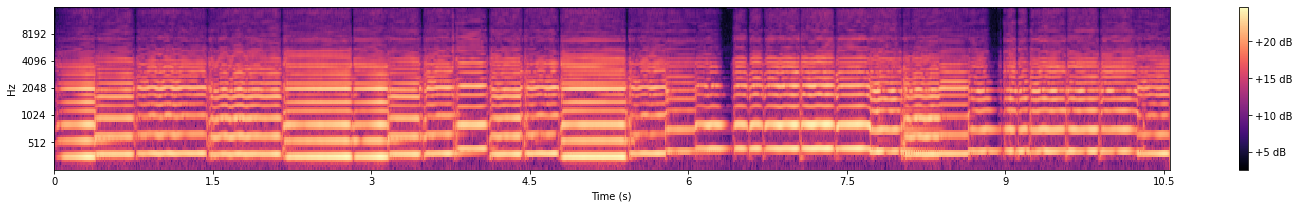

In [11]:
# Make spectrograms logarithmic
log_spects = [
    [
        np.log(single_win_spect + np.finfo(float).eps)
        for single_win_spect in multi_win_spect
    ] for multi_win_spect in spects_per_file
]
fig, axs = plt.subplots(figsize=(25,3))
img = melspecshow(log_spects[0][0], ax=axs)
fig.colorbar(img, ax=axs, format="%+2.f dB")

In [3]:
def _cnn_onset_processor_pad(data):
    """Pad the data by repeating the first and last frame 7 times."""
    pad_start = np.repeat(data[:1], 7, axis=0)
    pad_stop = np.repeat(data[-1:], 7, axis=0)
    return np.concatenate((pad_start, data, pad_stop))

In [75]:
# Prepare onsets
onset_vectors = [get_label_vector(sched, len(audio)/SR, HOP, SR)[CONTEXT:-CONTEXT-1]
    for (sched, audio) in zip(onset_schedules, audios)
]
# Make sure onehot vector contains right amount of 1:s
[print("Len of onset list: {}\n"
        "Sum of onehot vector: {}\n"
        "Len of onehot vector: {}".format(
            len(sched),
            np.sum(vec),
            len(vec)
        )) for (sched, vec) in zip(onset_schedules, onset_vectors)]

NameError: name 'onset_schedules' is not defined

In [84]:
mm_proc_frames = np.load("results/processor_test/prep.npy")
mm_proc_frames = _cnn_onset_processor_pad(mm_proc_frames)
mm_proc_frames.shape

(1070, 80, 3)

In [94]:

mm_proc_frames.sum()

-394389.75

In [88]:
inv_std = np.load("models/bock2013pret_inv_std.npy")
mean = np.load("models/bock2013pret_mean.npy")
mm_frames_normalized = (mm_proc_frames - np.reshape(mean, (1,80,3)))*np.reshape(inv_std, (1,80,3))
mm_frames_normalized = mm_frames_normalized.reshape((1,mm_frames_normalized.shape[0],80,3))
mm_frames_normalized.min(), mm_frames_normalized.max()


(-1.1668240167396324, 0.9492300645795243)

In [89]:
with open("models/bock2013pret-tf.pkl", 'rb') as handle:
    base_model =pickle.load(handle)

In [90]:
base_model.layers[1].get_weights()[0].shape

(7, 3, 3, 10)

In [120]:
kernel = np.zeros((1070, 80, 3))
kernel[0:7,0:3,:] = base_model.layers[1].get_weights()[0][:,:,:,0]
out = kernel * mm_frames_normalized.reshape((1070,80,3)) + base_model.layers[1].get_weights()[1][0]
act = np.tanh(out)
print(act.sum())

-251127.17764365269


In [100]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(mm_frames_normalized.shape[1], 80, 3)),

    tf.keras.layers.Conv2D(

            filters = 10,
            kernel_size = (7,3),
            strides = (1,1),
            padding = 'valid',
            data_format = 'channels_last',
            activation = 'tanh',
            use_bias = True
    )

])

In [ ]:
'''
    tf.keras.layers.MaxPooling2D(
        pool_size=(1, 3), 
            strides=(1,3)
    ),
    tf.keras.layers.Conv2D(
        activation = 'tanh',
        filters = 20,
        kernel_size = (3,3),
        strides = 1
    ), 
    tf.keras.layers.MaxPooling2D(
        pool_size=(1, 3), 
            strides=(1,3)
    ),
    '''

In [101]:
model.layers[0].set_weights(base_model.layers[1].get_weights())
#model.layers[2].set_weights(base_model.layers[3].get_weights())

In [102]:
layer_output = model.predict(mm_frames_normalized)
layer_output.mean()

-0.5372767

In [55]:
output_resh = layer_output.reshape((1062,8,20))
output_seg = [output_resh[i:i+7,:,:] for i in range(1056)]
output_seg = np.array(output_seg)
output_seg = output_seg.reshape((len(output_seg), -1))
output_seg.shape

(1056, 1120)

In [76]:
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

In [77]:
def custom_activation(x):
    return (K.tanh(x*0.5) + 1) * 0.5
get_custom_objects().update({'custom_activation': Activation(custom_activation)})

In [78]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=output_seg.shape),
    tf.keras.layers.Dense(256, activation = Activation(custom_activation, name='SpecialActivation')),
    tf.keras.layers.Dense(1, activation = Activation(custom_activation, name='SpecialActivation')), 
])

In [79]:
model2.layers[0].set_weights(base_model.layers[6].get_weights())
model2.layers[1].set_weights(base_model.layers[7].get_weights())

In [83]:
layer_output_2 = model2.predict(output_seg.reshape(1,output_seg.shape[0], output_seg.shape[1]))
layer_output_2.sum()
debug_pred = layer_output_2.reshape((-1))
plt.figure(figsize=(25,4))
#plt.plot(debug_pred)
plt.plot(np.convolve(debug_pred, np.hamming(7), mode='same'))

ModuleNotFoundError: No module named 'madmom'

In [63]:
inv_std_resh = np.reshape(inv_std, (1,80,1,3))
mean_resh = np.reshape(mean, (1,80,1,3))

In [69]:
np.sum((mm_proc_frames - np.reshape(mean, (1,80,3)))*np.reshape(inv_std, (1,80,3)))


60564.552902900556

In [70]:
data = np.transpose(mm_spects, axes=[0,2,1,3])
normalized_data = (data - mean_resh)*inv_std_resh
normalized_data.sum()

905996.303575408

In [58]:
# Load model
with open("models/bock2013pret-tf.pkl", 'rb') as handle:
    model =pickle.load(handle)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, 15, 80, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 9, 78, 10)         640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 26, 10)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 24, 20)         1820      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 8, 20)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1120)              0

In [71]:
intermediate = tf.keras.Model(model.input, outputs=model.get_layer('conv2d').output)

intermediate.predict(normalized_data).sum()

-3977391.2

(1041,)


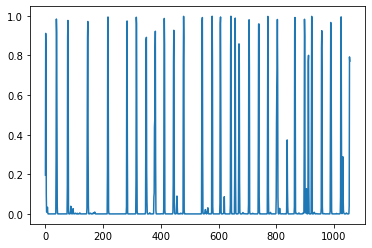

In [66]:
CONTEXT = 7
madmom_act_fn = np.load("results/madmomCNNOnsetProcessor/42954_FreqMan_hoochie_violin_pt1.npy")
print(madmom_act_fn[CONTEXT:-CONTEXT-1].shape)
plt.plot(madmom_act_fn)

NameError: name 'onset_vectors' is not defined

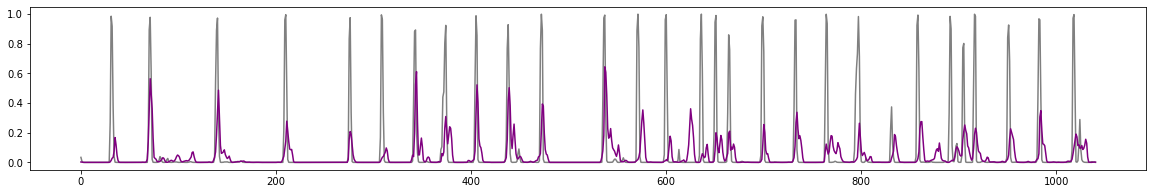

In [69]:
#pred_function = model.predict(normalized_data).reshape((-1))
#smoothed_pred_function = np.convolve(pred_function, np.hamming(7), mode='same')
plt.figure(figsize=(20,3))
plt.plot(madmom_act_fn[CONTEXT:-CONTEXT-1], c='gray')
plt.plot(debug_pred[CONTEXT:-CONTEXT-1], c='purple')
onset_idx = np.where(onset_vectors[0]==1)[0]
plt.scatter(onset_idx, np.zeros_like(onset_idx) + .5, marker='x', c='r' )
plt.legend(["Black-box detection function", "Implemented detection function (kernel size=5)", "Annotated onsets"])

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_1 (Permute)         (None, 15, 80, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 78, 10)         640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 26, 10)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 24, 20)         1820      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 8, 20)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1120)             

In [32]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    class_weight = {0: 1., 1: 1/0.035},
    epochs = 10,
    batch_size = 256
)

Epoch 1/10
177/177 [==============================] - 59s 293ms/step - loss: 0.1448 - fp01: 994.0000 - fn01: 39568.0000 - fp05: 2.0000 - fn05: 40560.0000 - val_loss: 0.0744 - val_fp01: 244.0000 - val_fn01: 11994.0000 - val_fp05: 0.0000e+00 - val_fn05: 12238.0000
Epoch 2/10
177/177 [==============================] - 35s 198ms/step - loss: 0.1116 - fp01: 1709.0000 - fn01: 38853.0000 - fp05: 5.0000 - fn05: 40557.0000 - val_loss: 0.0674 - val_fp01: 330.0000 - val_fn01: 11908.0000 - val_fp05: 0.0000e+00 - val_fn05: 12238.0000
Epoch 3/10
177/177 [==============================] - 46s 260ms/step - loss: 0.1031 - fp01: 1781.0000 - fn01: 38781.0000 - fp05: 6.0000 - fn05: 40556.0000 - val_loss: 0.0638 - val_fp01: 269.0000 - val_fn01: 11969.0000 - val_fp05: 1.0000 - val_fn05: 12237.0000
Epoch 4/10
177/177 [==============================] - 41s 230ms/step - loss: 0.0994 - fp01: 1801.0000 - fn01: 38761.0000 - fp05: 2.0000 - fn05: 40560.0000 - val_loss: 0.0624 - val_fp01: 377.0000 - val_fn01: 11861.

KeyboardInterrupt: 

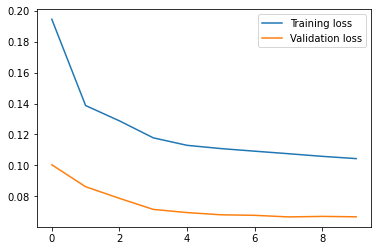

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Training loss", "Validation loss"])

ZeroDivisionError: float division by zero

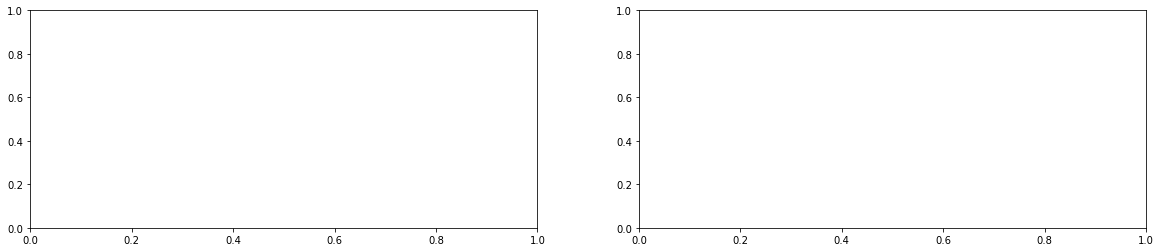

In [13]:
fig, axs = plt.subplots(1,2,figsize=(20,4))
# Prec. training
axs[0].plot([tp/(fp+tp) for (tp, fp) in zip(history.history['tp'], history.history['fp'])], color='lightblue')
# Rec. training
axs[0].plot([tp/(fn+tp) for (tp, fn) in zip(history.history['tp'], history.history['fn'])], color='lightgreen')
# F-measure
axs[0].plot([2*tp/(2*tp+fp+fn) for (tp, fp, fn) in zip(history.history['tp'], history.history['fp'], history.history['fn'])], 'k:')
axs[0].legend(["Precision", "Recall", "F-measure"])

# Prec. training
axs[1].plot([tp/(fp+tp) for (tp, fp) in zip(history.history['val_tp'], history.history['val_fp'])], color='lightblue')
# Rec. training
axs[1].plot([tp/(fn+tp) for (tp, fn) in zip(history.history['val_tp'], history.history['val_fn'])], color='lightgreen')
# F-measure
axs[1].plot([2*tp/(2*tp+fp+fn) for (tp, fp, fn) in zip(history.history['val_tp'], history.history['val_fp'], history.history['val_fn'])], 'k:')
axs[1].legend(["Precision", "Recall", "F-measure"])

In [ ]:
training_name = "3787-nofuzz-100eps"
with open('results/cnn-training-220316/{}.pickle'.format(training_name), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [14]:
model.evaluate(X_test, y_test)


113/113 [==============================] - 1s 9ms/step - loss: 0.0538 - tp: 0.0000e+00 - fp: 0.0000e+00 - fn: 3475.0000 - f1: 0.0000e+00


[0.053785886615514755, 0.0, 0.0, 3475.0, 0.0]

## Audio analysis and onset extraction

In [15]:
test_index = split_idx[-n_test:][0]
audio = tfio.audio.AudioIOTensor('datasets/initslurtest_vn/initslurtest_vn_wav/slurtest{:02d}.wav'.format(test_index))
audio_tensor = tf.squeeze(audio[:], axis=[-1])
audio_tensor = tf.cast(audio_tensor, tf.float32)/np.max(audio_tensor)
print("Test recording: ", test_index)

Test recording:  10


In [16]:
with open('datasets/initslurtest_vn/spectrogram/slurtest{:02d}.pickle'.format(test_index), 'rb') as handle:
    spects=pickle.load(handle)


In [17]:
onset_times = genfromtxt('datasets/initslurtest_vn/initslurtest_vn_annotations/{:02d}.txt'.format(test_index), delimiter=',')
times = np.arange(0, len(audio_tensor)/44100, 440/44100)
labels = get_label_vector(times, onset_times, fuzzy=False)
print("Number of true onsets: ", len(onset_times))

Number of true onsets:  52


In [18]:
with open('datasets/initslurtest_vn/frames/slurtest{:02d}.pickle'.format(test_index), 'rb') as handle:
    frames=pickle.load(handle)
print(frames.shape)

(4020, 80, 15, 3)


Onsets detected:  52


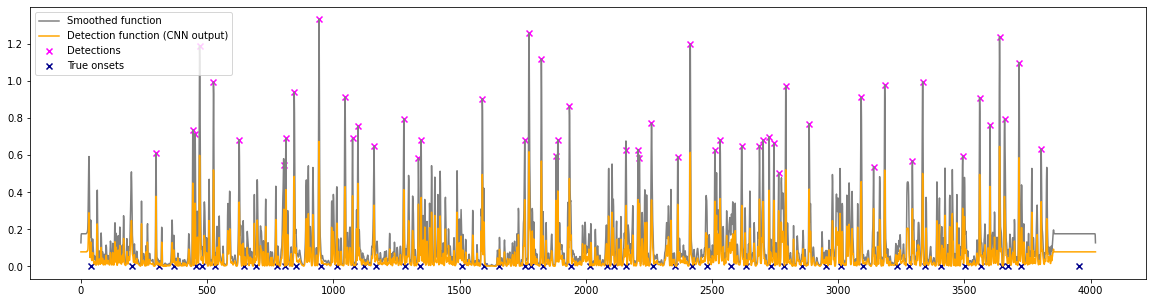

In [21]:
from scipy.signal import find_peaks
from librosa.util import peak_pick

kernel_size = 5
threshold = 0.3

pred_onsets = model.predict(frames)[:,0]
plt.figure(figsize=(20,5))

smoothed = np.convolve(pred_onsets, np.hamming(kernel_size), mode='same')
plt.plot(smoothed, c='gray')
plt.plot(pred_onsets, c='orange')

peaks, _ = find_peaks(pred_onsets, height=threshold)
print("Onsets detected: ", len(peaks))
plt.scatter(peaks, smoothed[peaks], c='magenta', marker='x')

plt.scatter(onset_times*sr/HOP, np.zeros_like(onset_times), marker='x', c='darkblue')
plt.legend(["Smoothed function", "Detection function (CNN output)", "Detections", "True onsets"])
plt.show()

In [22]:
from analyze_detection import evaluate

true = onset_times
pred = peaks*HOP/sr

[CD,FN,FP,doubles,merged] = evaluate(true, pred, tol_sec=0.25)

print("Precision: {:.1f} %".format( 100*CD/(CD+FP)))
print("Recall: {:.1f} %".format( 100*CD/(CD+FN)))

Precision: 58.2 %
Recall: 61.5 %


In [ ]:
#f = open("datasets/initslurtest_vn/model-output/bockmodel-220315-slurtest{:02d}.txt".format(test_index), "w")
#for i in range(len(peaks)):
#    f.write(str(np.round((peaks[i]+7)*440/44100, decimals=2))+ "\n")
#f.close()